In [90]:
%matplotlib inline

import numpy as np

import pandas as pd
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
sns.set_style('whitegrid')

In [92]:
df = pd.read_csv('../data/prices_round_3_day_0.csv', index_col='timestamp', delimiter=';')
df1 = pd.read_csv('../data/prices_round_3_day_1.csv', index_col='timestamp', delimiter=';')
df2 = pd.read_csv('../data/prices_round_3_day_2.csv', index_col='timestamp', delimiter=';')
df.head(10)

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
timestamp,,,,,,,,,,,,,,,,
0,0,DIVING_GEAR,99999.0,6.0,99998.0,19.0,NaN,NaN,100001.0,6.0,100002.0,19.0,NaN,NaN,100000.0,0.000000
0,0,PEARLS,9998.0,1.0,9995.0,30.0,NaN,NaN,10005.0,30.0,NaN,NaN,NaN,NaN,10001.5,0.000000
0,0,COCONUTS,8113.0,205.0,NaN,NaN,NaN,NaN,8116.0,205.0,NaN,NaN,NaN,NaN,8114.5,0.000000
0,0,BERRIES,3997.0,19.0,3996.0,58.0,NaN,NaN,4003.0,19.0,4005.0,58.0,NaN,NaN,4000.0,0.000000
0,0,BANANAS,4893.0,1.0,4892.0,30.0,NaN,NaN,4899.0,30.0,NaN,NaN,NaN,NaN,4896.0,0.000000
0,0,DOLPHIN_SIGHTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,0.000000
0,0,PINA_COLADAS,15225.0,82.0,NaN,NaN,NaN,NaN,15228.0,82.0,NaN,NaN,NaN,NaN,15226.5,0.000000
100,0,DOLPHIN_SIGHTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,0.000000
100,0,BERRIES,3996.0,12.0,3995.0,59.0,NaN,NaN,4003.0,12.0,4004.0,59.0,NaN,NaN,3999.5,20.396484


# Seasonal Decomposition

In [93]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

## Pearls Analysis

In [94]:
df_pearls = df.loc[df['product']=='PEARLS'][['mid_price']]

In [95]:
components_pearls = tsa.seasonal_decompose(df_pearls['mid_price'], model='additive', period=100)

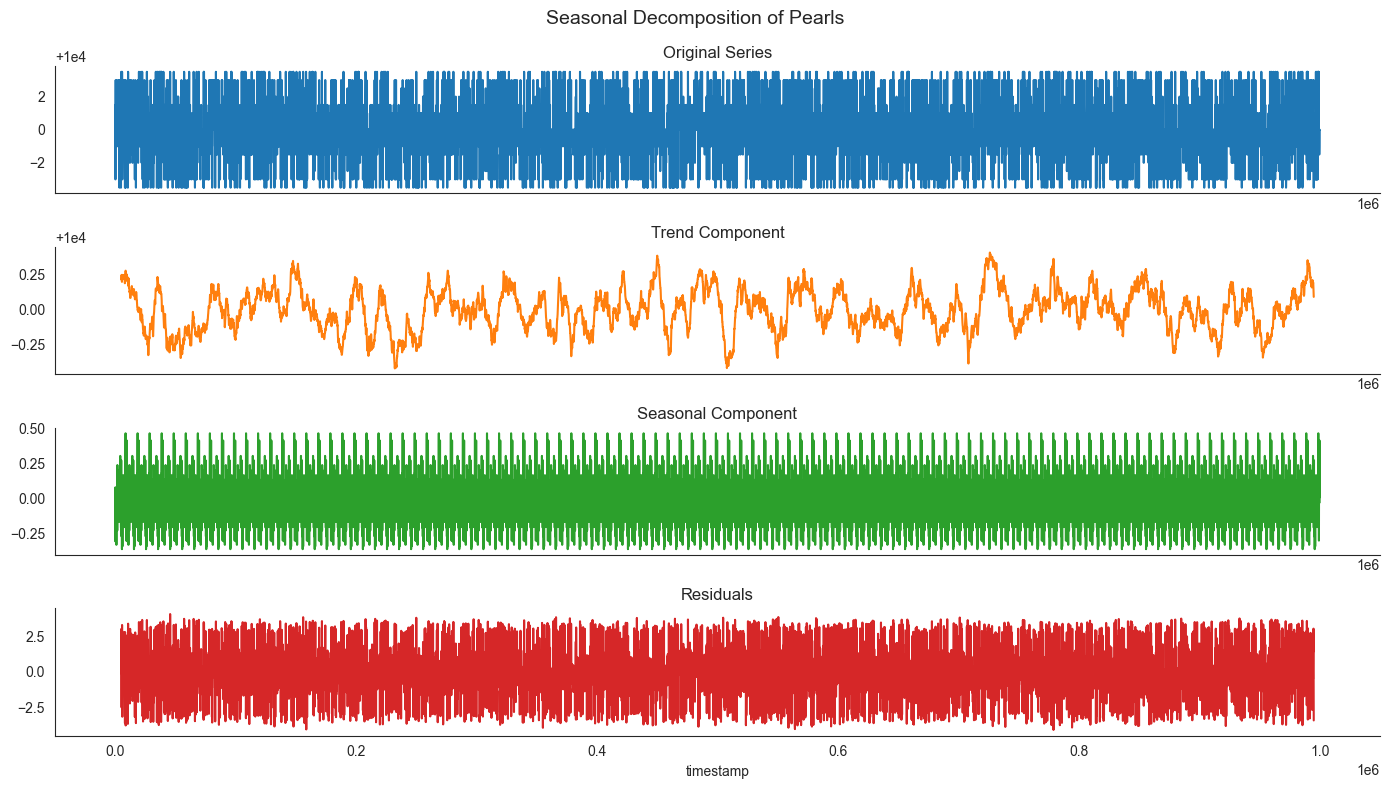

In [96]:
ts_pearls = (df_pearls['mid_price'].to_frame('Original')
      .assign(Trend=components_pearls.trend)
      .assign(Seasonality=components_pearls.seasonal)
      .assign(Residual=components_pearls.resid))
with sns.axes_style('white'):
    ts_pearls.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Pearls', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


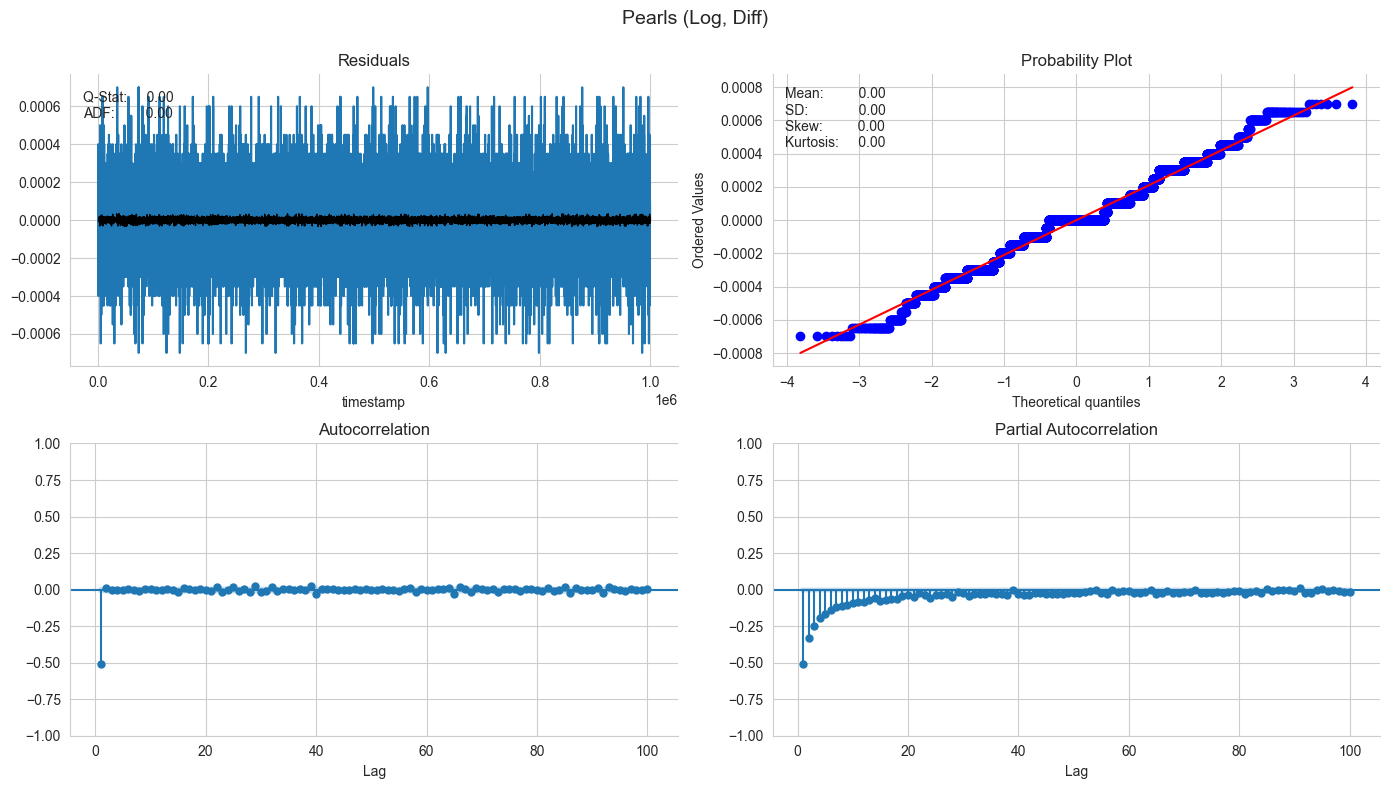

In [97]:
pearls_log = np.log(df_pearls['mid_price'])
pearls_log_diff = pearls_log.diff().dropna()

plot_correlogram(pearls_log_diff, lags=100, title='Pearls (Log, Diff)')

## Bananas Analysis

In [98]:
df_bananas = df.loc[df['product']=='BANANAS'][['mid_price']]

In [99]:
components_bananas = tsa.seasonal_decompose(df_bananas['mid_price'], model='additive', period=100)

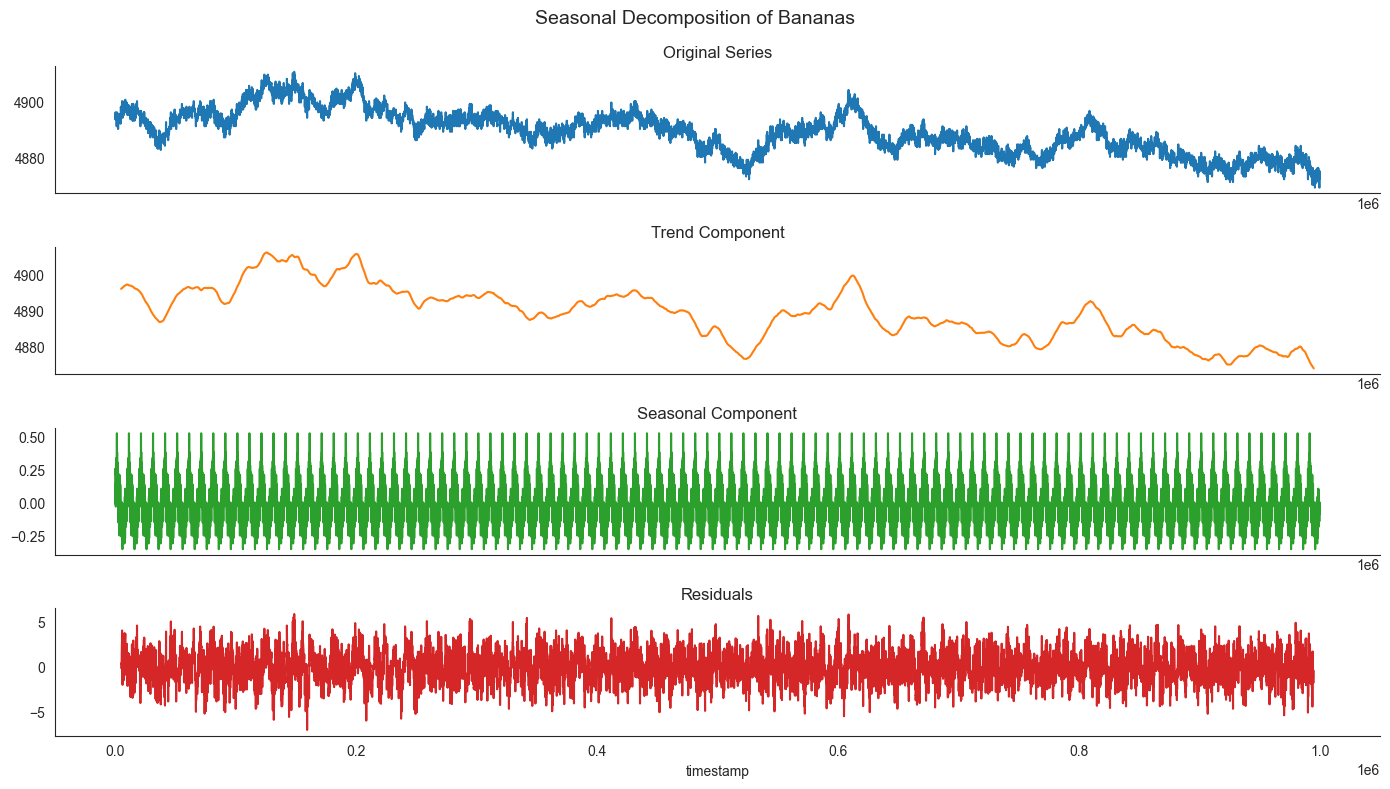

In [100]:
ts_bananas = (df_bananas['mid_price'].to_frame('Original')
      .assign(Trend=components_bananas.trend)
      .assign(Seasonality=components_bananas.seasonal)
      .assign(Residual=components_bananas.resid))
with sns.axes_style('white'):
    ts_bananas.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Bananas', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


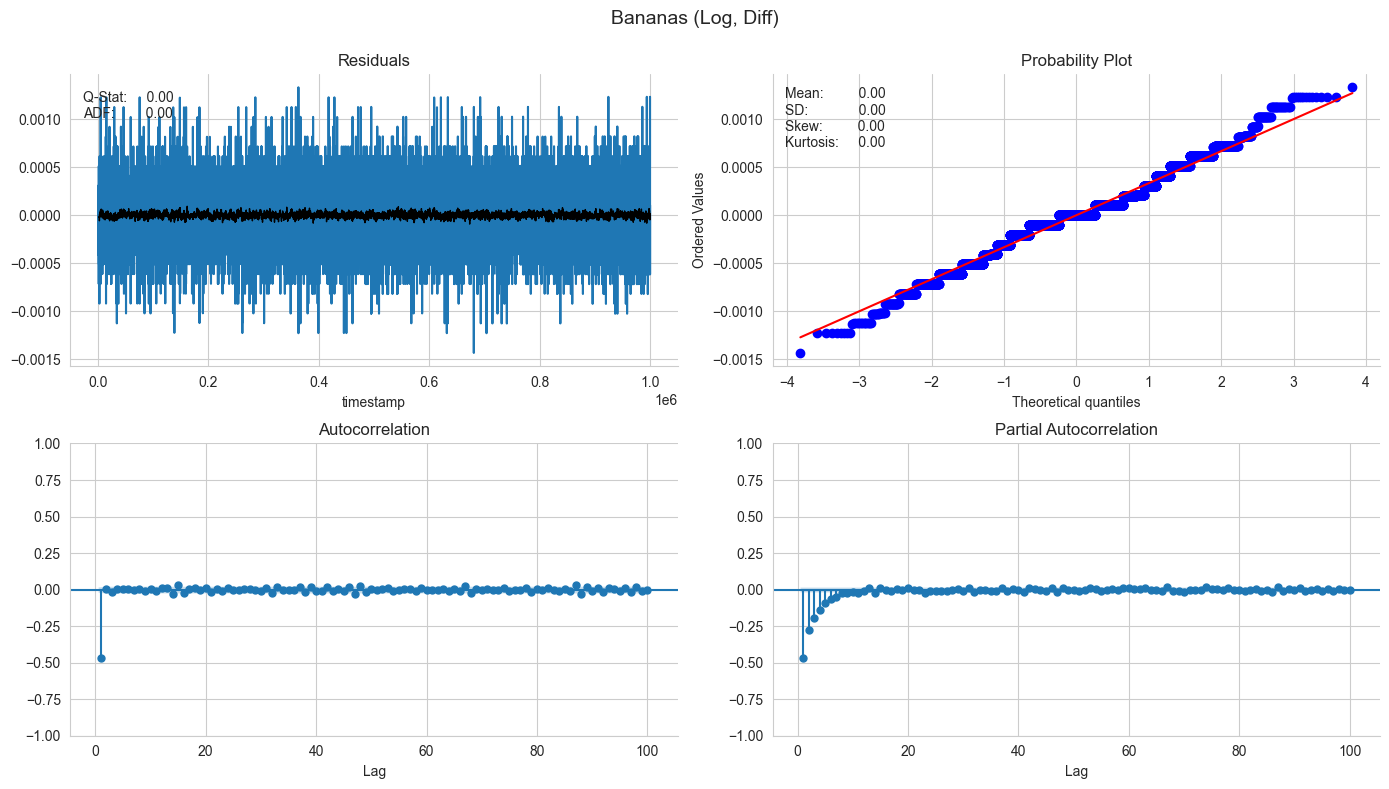

In [101]:
bananas_log = np.log(df_bananas['mid_price'])
bananas_log_diff = bananas_log.diff().dropna()

plot_correlogram(bananas_log_diff, lags=100, title='Bananas (Log, Diff)')

## Pina Colada Analysis

In [102]:
df_pina_coladas = df.loc[df['product']=='PINA_COLADAS'][['mid_price']]

In [103]:
components_pina_coladas = tsa.seasonal_decompose(df_pina_coladas['mid_price'], model='additive', period=100)

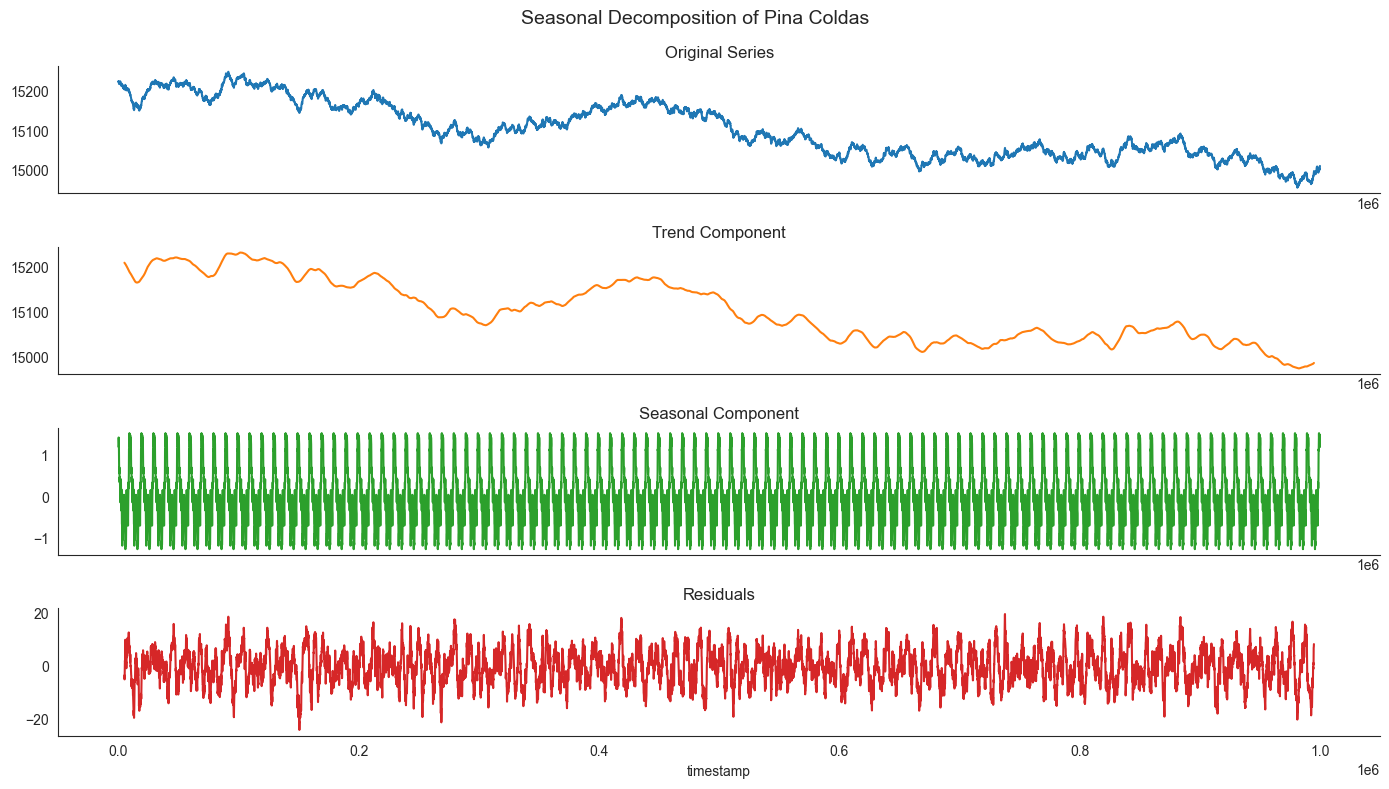

In [104]:
ts_pina_coladas = (df_pina_coladas['mid_price'].to_frame('Original')
      .assign(Trend=components_pina_coladas.trend)
      .assign(Seasonality=components_pina_coladas.seasonal)
      .assign(Residual=components_pina_coladas.resid))
with sns.axes_style('white'):
    ts_pina_coladas.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Pina Coldas', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


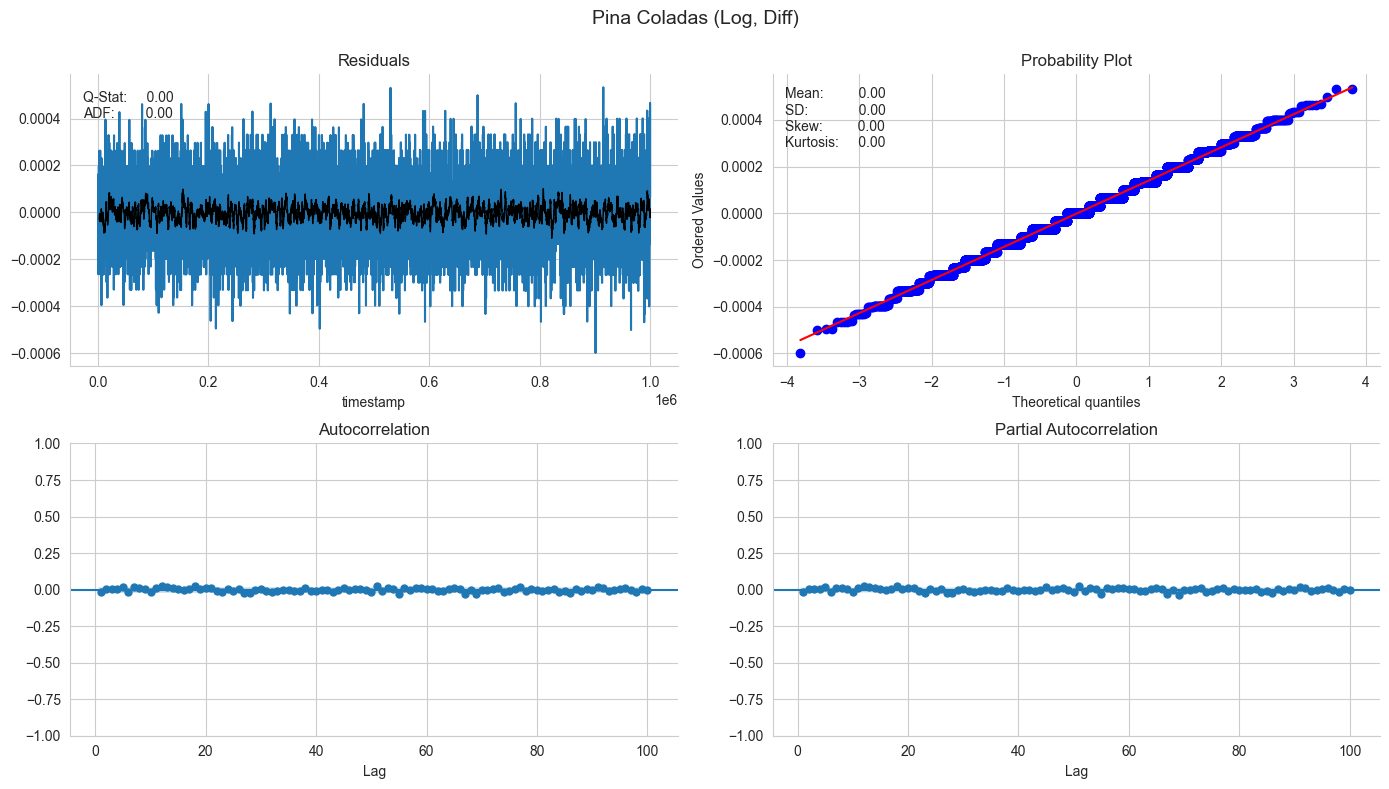

In [105]:
pina_coladas_log = np.log(df_pina_coladas['mid_price'])
pina_coladas_log_diff = pina_coladas_log.diff().dropna()

plot_correlogram(pina_coladas_log_diff, lags=100, title='Pina Coladas (Log, Diff)')

## Coconut Analysis

In [106]:
df_coconut = df.loc[df['product']=='COCONUTS'][['mid_price']]

In [107]:
components_coconut = tsa.seasonal_decompose(df_coconut['mid_price'], model='additive', period=100)

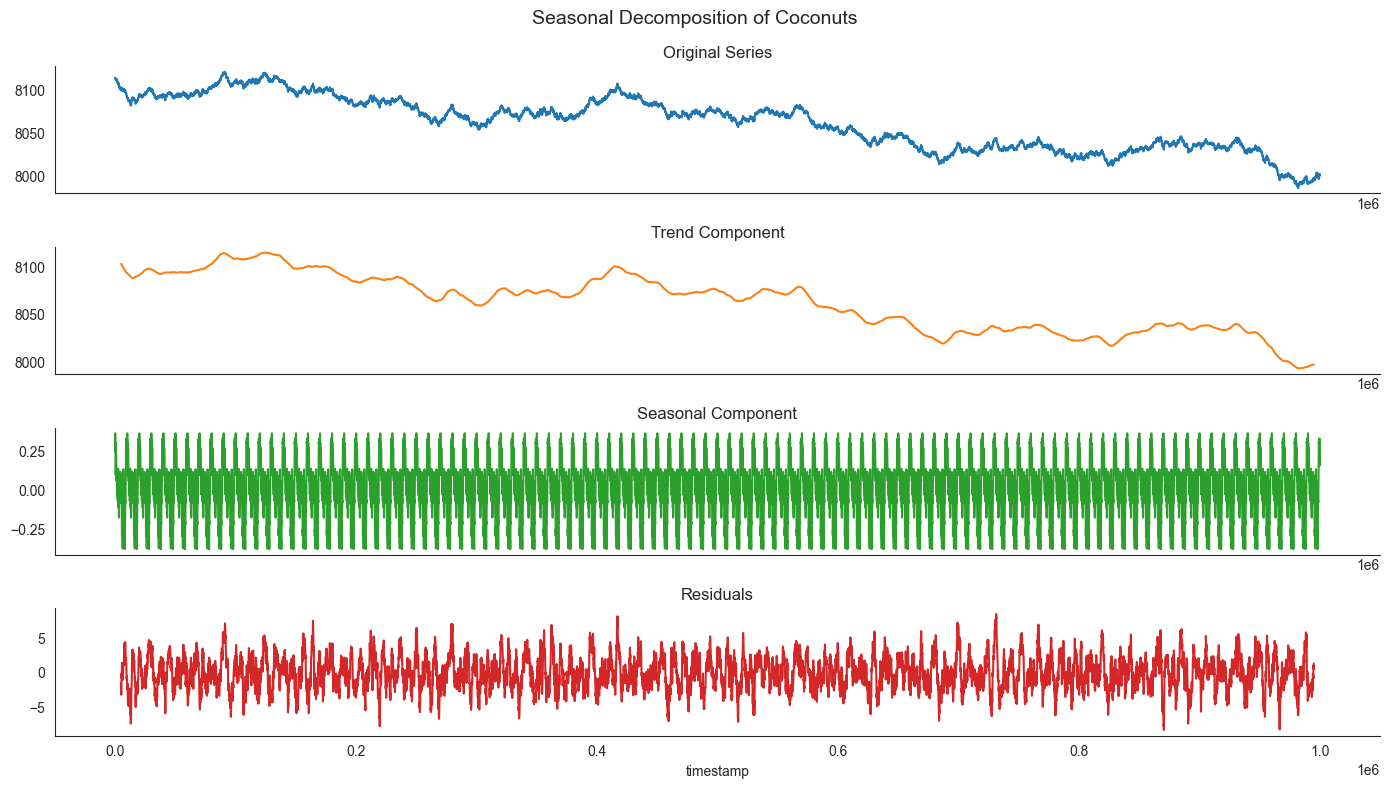

In [108]:
ts_coconut = (df_coconut['mid_price'].to_frame('Original')
      .assign(Trend=components_coconut.trend)
      .assign(Seasonality=components_coconut.seasonal)
      .assign(Residual=components_coconut.resid))
with sns.axes_style('white'):
    ts_coconut.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Coconuts', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


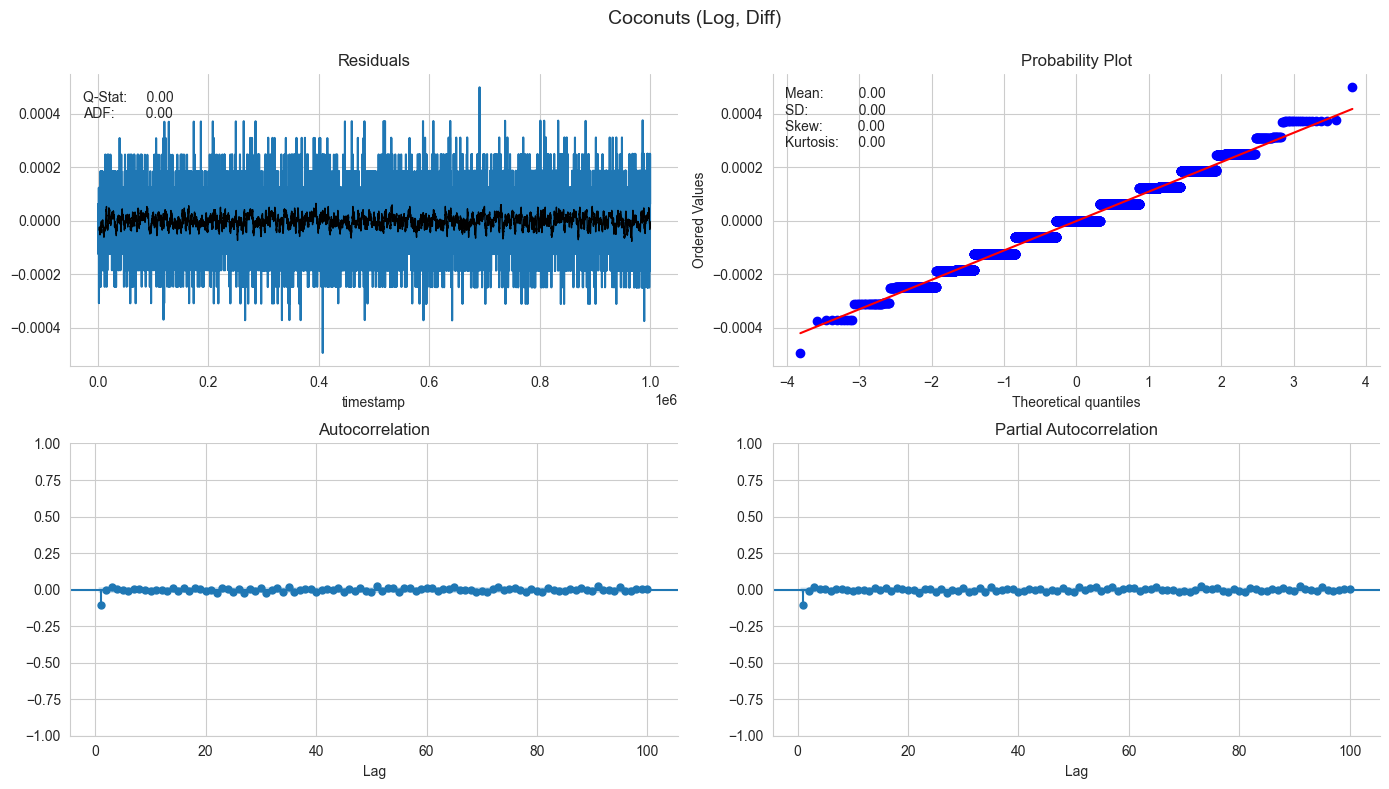

In [109]:
coconut_log = np.log(df_coconut['mid_price'])
coconut_log_diff = coconut_log.diff().dropna()

plot_correlogram(coconut_log_diff, lags=100, title='Coconuts (Log, Diff)')

## Berries

In [110]:
# df = pd.concat([df,df1,df2], ignore_index=True).reset_index(drop=True)
# df_berries = df1.loc[df['product']=='BERRIES'][['mid_price']].reset_index(drop=True)
df_berries = df.loc[df['product']=='BERRIES'][['mid_price']]

In [111]:
components_berries = tsa.seasonal_decompose(df_berries['mid_price'], model='additive', period=100)

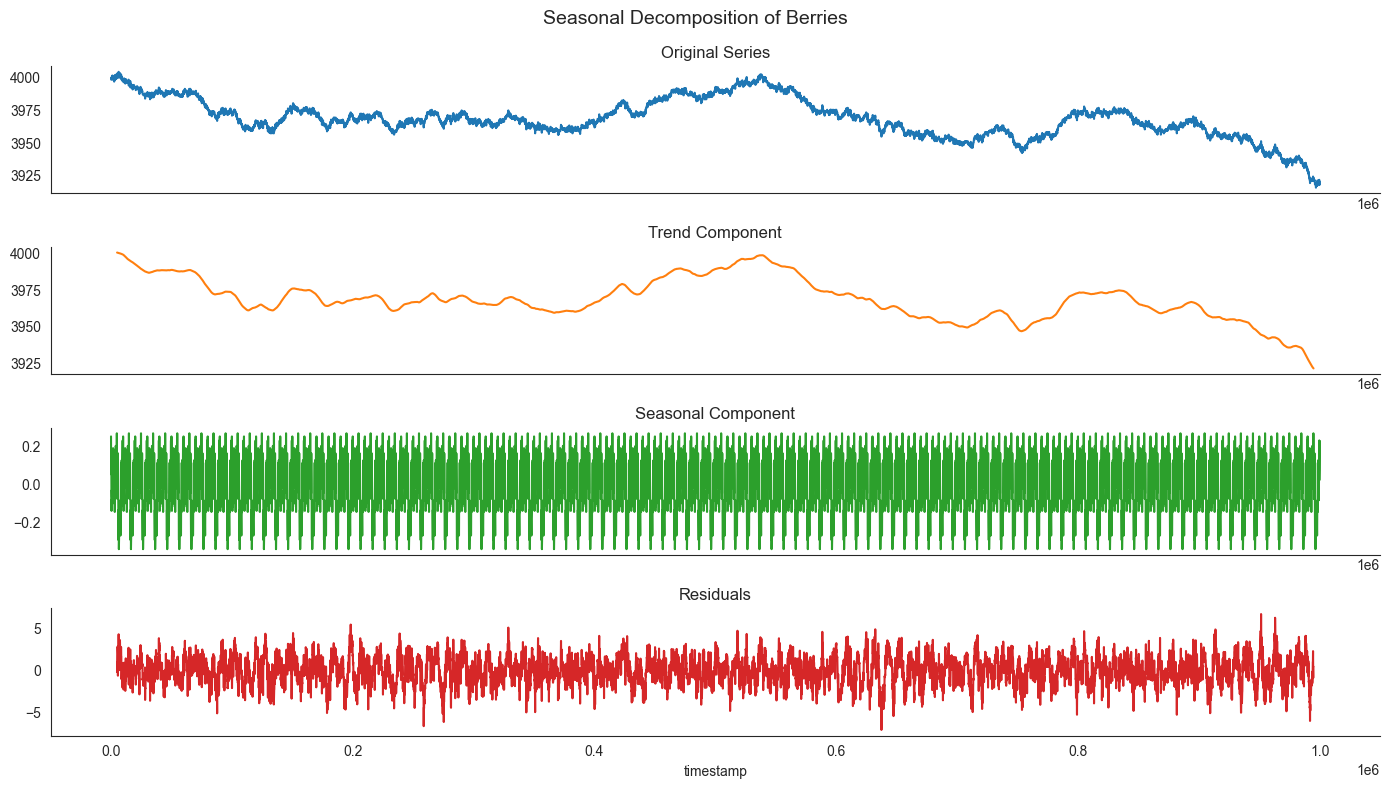

In [112]:
ts_berries = (df_berries['mid_price'].to_frame('Original')
      .assign(Trend=components_berries.trend)
      .assign(Seasonality=components_berries.seasonal)
      .assign(Residual=components_berries.resid))
with sns.axes_style('white'):
    ts_berries.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Berries', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


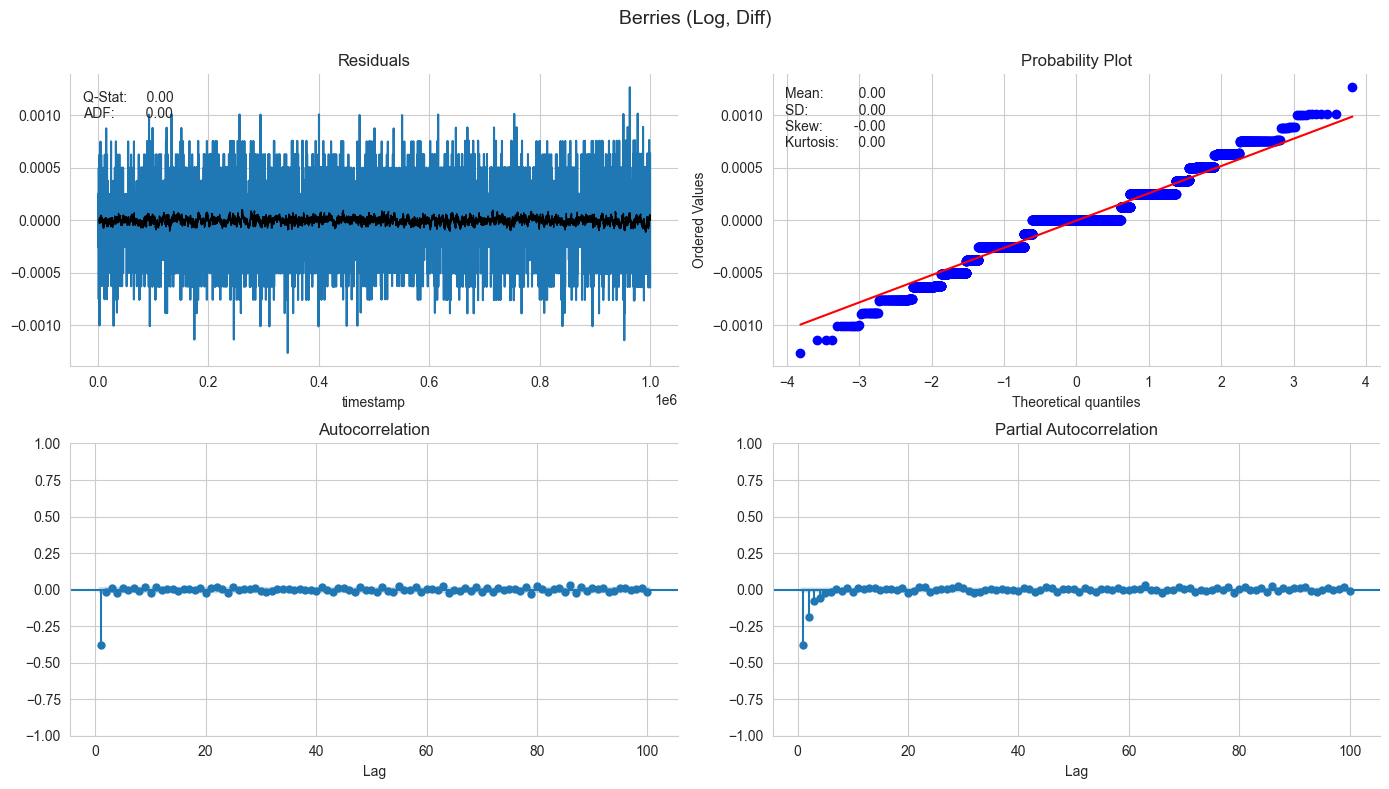

In [113]:
berries_log = np.log(df_berries['mid_price'])
berries_log_diff = berries_log.diff().dropna()

plot_correlogram(berries_log_diff, lags=100, title='Berries (Log, Diff)')

## Diving Gear

In [125]:
df = pd.concat([df,df1,df2], ignore_index=True).reset_index(drop=True)
df_diving_gear = df.loc[df['product']=='DIVING_GEAR'][['mid_price']]

In [126]:
components_diving_gear = tsa.seasonal_decompose(df_diving_gear['mid_price'], model='additive', period=100)

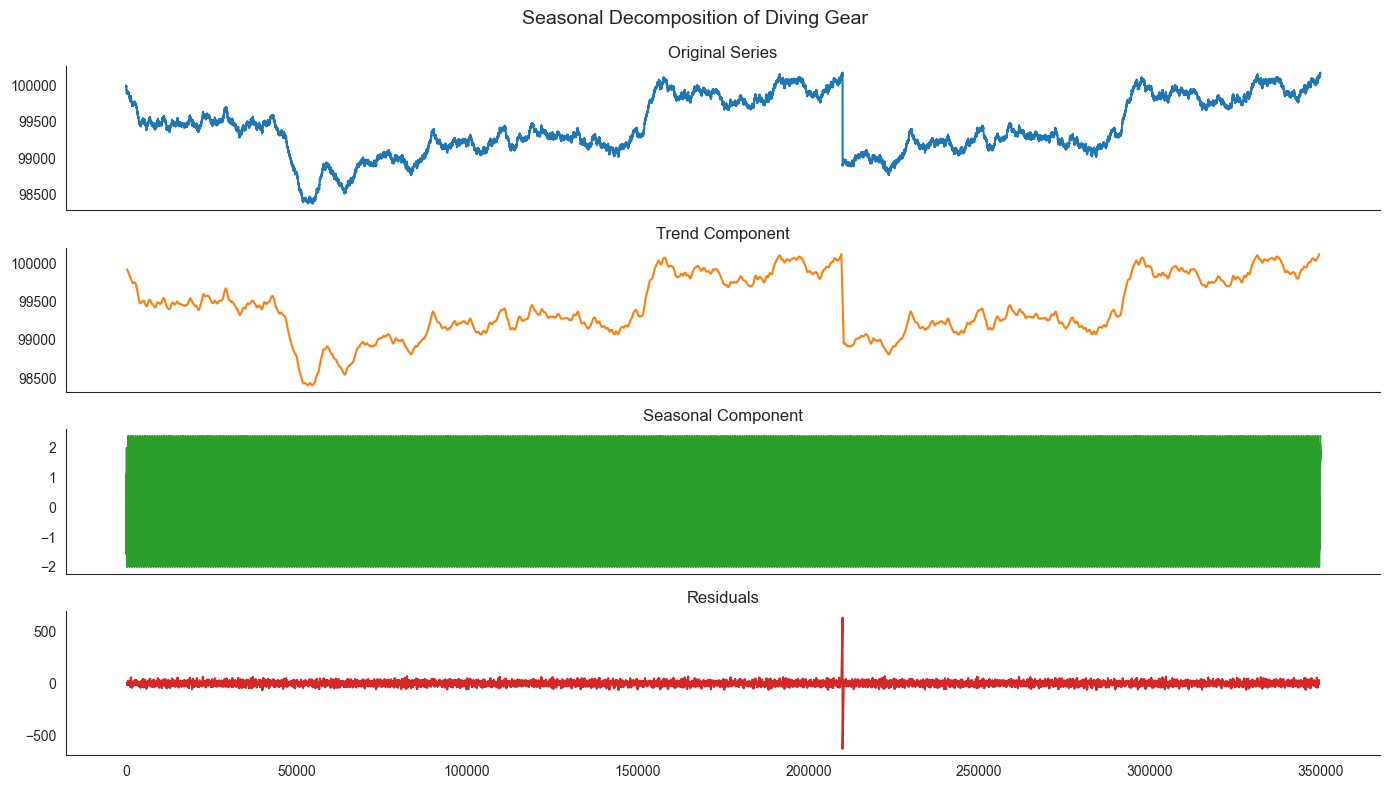

In [127]:
ts_diving_gear = (df_diving_gear['mid_price'].to_frame('Original')
      .assign(Trend=components_diving_gear.trend)
      .assign(Seasonality=components_diving_gear.seasonal)
      .assign(Residual=components_diving_gear.resid))
with sns.axes_style('white'):
    ts_diving_gear.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Diving Gear', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


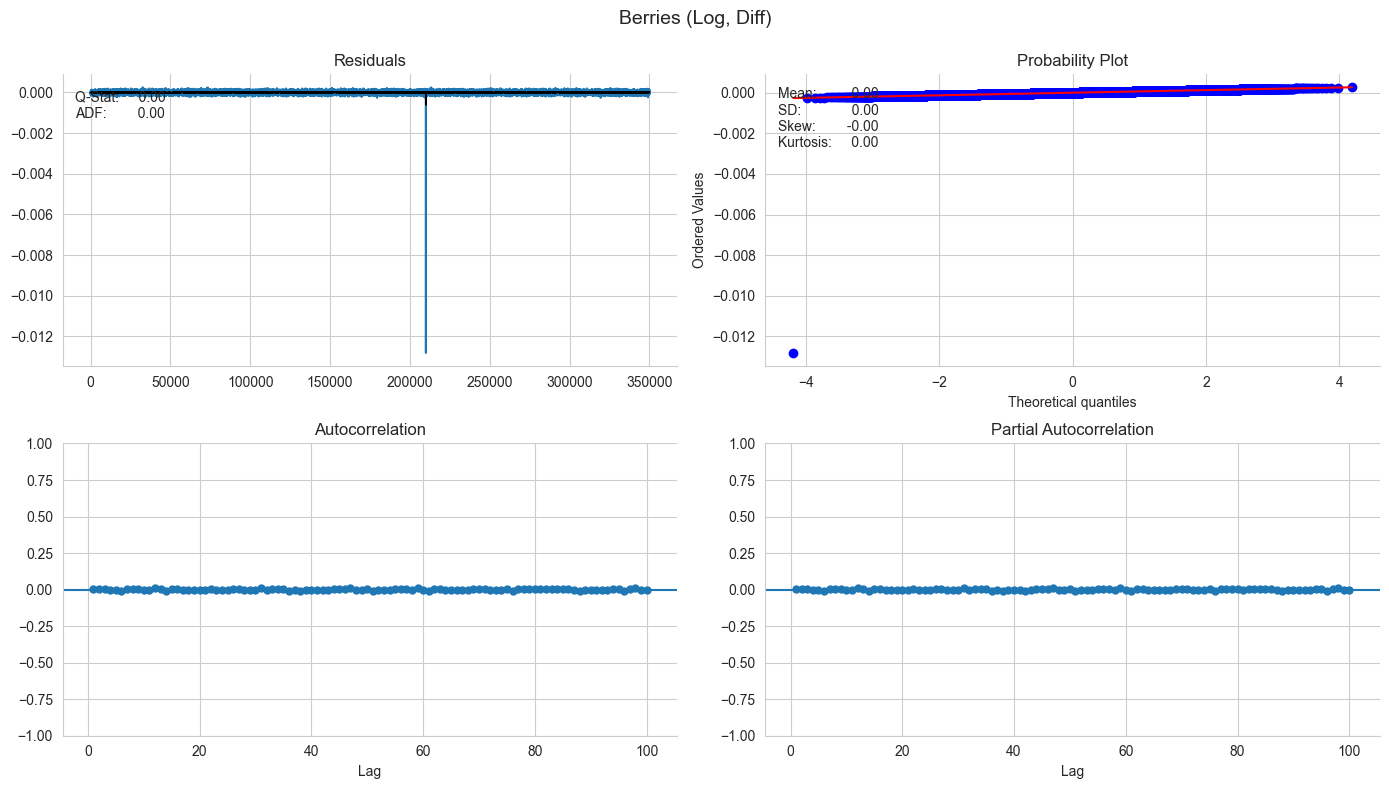

In [128]:
diving_gear_log = np.log(df_diving_gear['mid_price'])
diving_gear_log_diff = diving_gear_log.diff().dropna()

plot_correlogram(diving_gear_log_diff, lags=100, title='Berries (Log, Diff)')

## Dolphin Sightings

In [129]:
df_dolphin_sightings = df.loc[df['product']=='DOLPHIN_SIGHTINGS'][['mid_price']]

In [130]:
components_dolphin_sightings = tsa.seasonal_decompose(df_dolphin_sightings['mid_price'], model='additive', period=100)

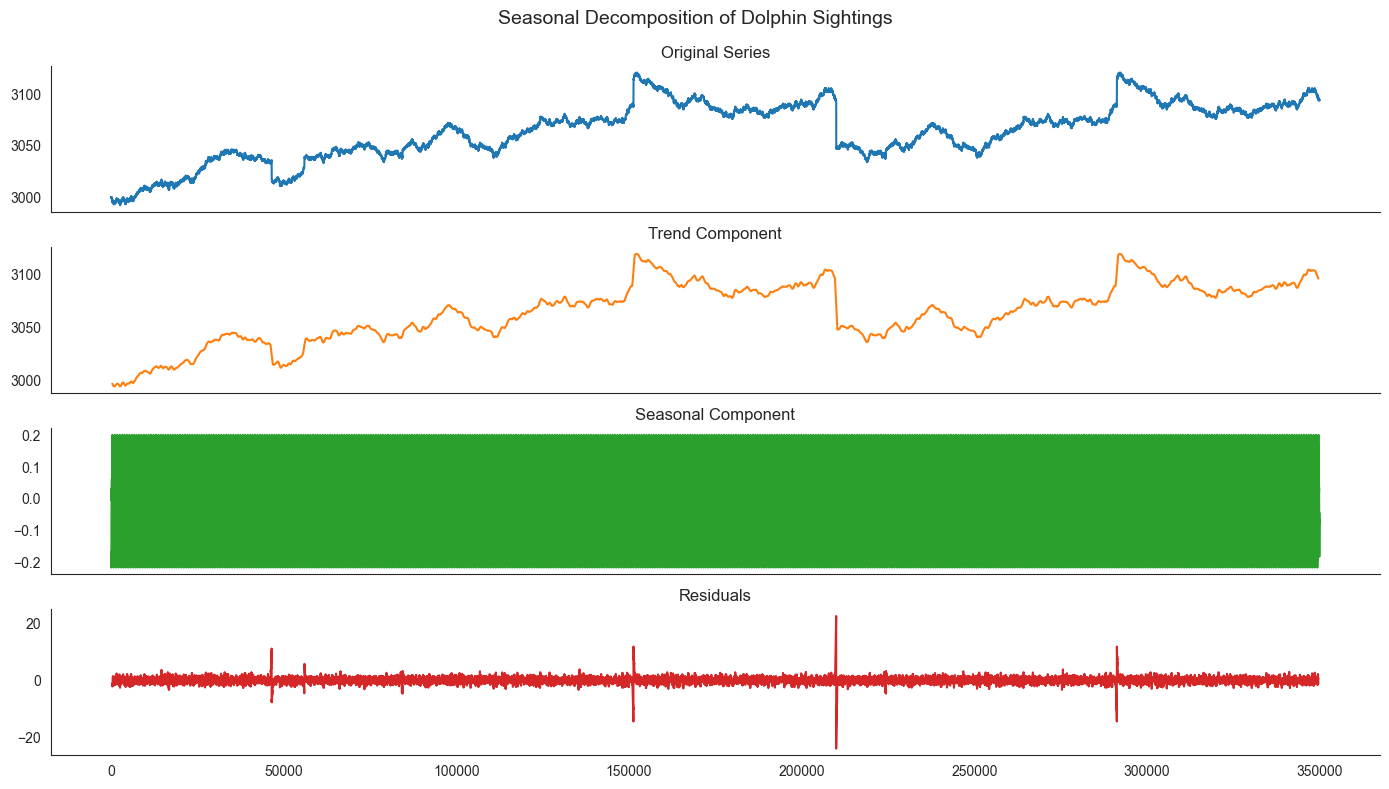

In [131]:
ts_dolphin_sightings = (df_dolphin_sightings['mid_price'].to_frame('Original')
      .assign(Trend=components_dolphin_sightings.trend)
      .assign(Seasonality=components_dolphin_sightings.seasonal)
      .assign(Residual=components_dolphin_sightings.resid))
with sns.axes_style('white'):
    ts_dolphin_sightings.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Dolphin Sightings', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


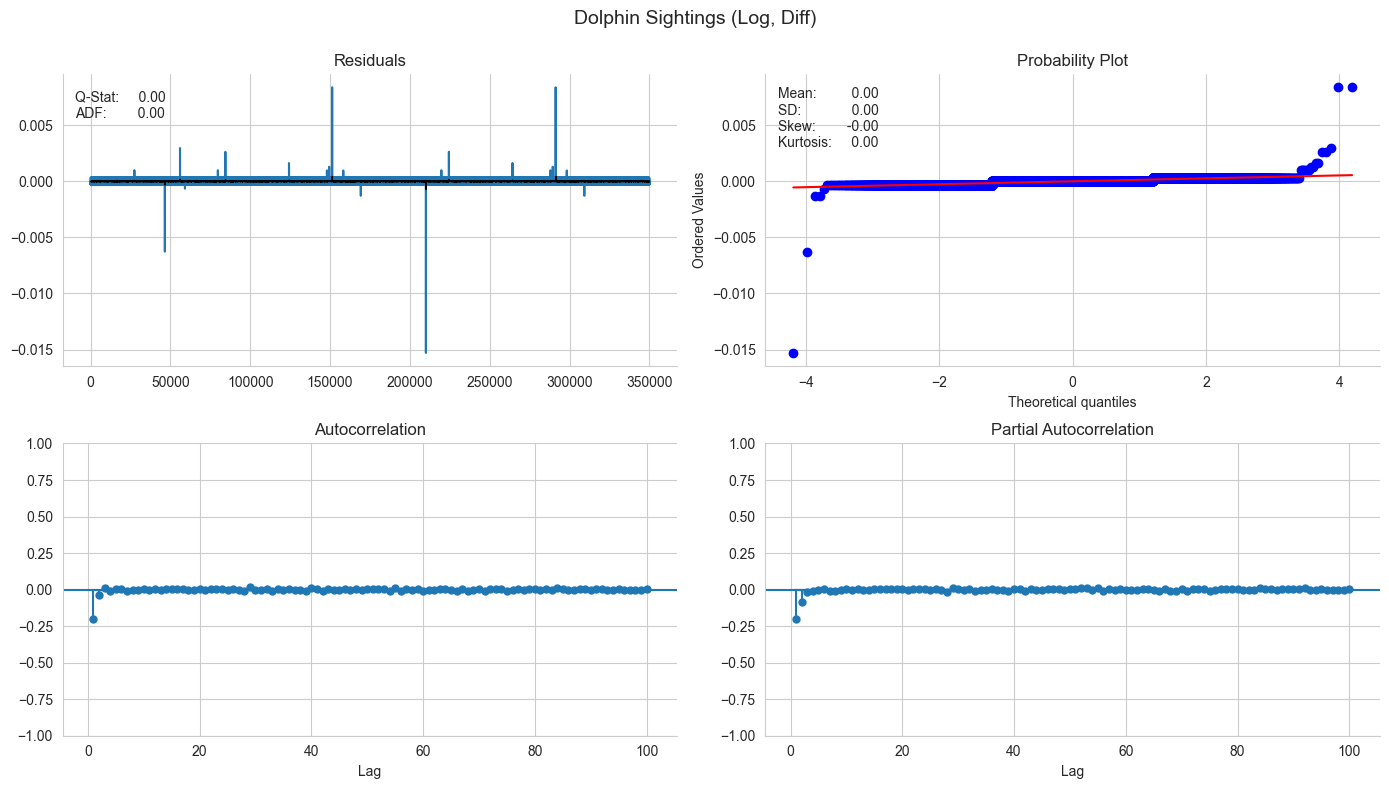

In [134]:
dolphin_sightings_log = np.log(df_dolphin_sightings['mid_price'])
dolphin_sightings_log_diff = dolphin_sightings_log.diff().dropna()

plot_correlogram(dolphin_sightings_log_diff, lags=100, title='Dolphin Sightings (Log, Diff)')